# Notebook for the Kaggle competition "Titanic"
Author: Dirk Ulbricht, dirk@neuefische.de

In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re, graphviz 

from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model, tree
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 
from sklearn.metrics import roc_curve, confusion_matrix,precision_recall_curve,roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 

import xgboost as xgb # note for installation use py-xgboost in conda

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
plt.style.use('seaborn')
np.random.seed(42)

### Variable description (from Kaggle)

| Variable | Definition                                 | Key                                            | Type        |
|:----------|:--------------------------------------------|:------------------------------------------------|-------------|
| Survived | Survival                                   | 0 = No, 1 = Yes                                | nominal     |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      | ordinal     |
| Sex      | Sex                                        |                                                | dichotomous |
| Age      | Age in years                               |                                                | ratio       |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                | ratio       |
| Parch    | # of parents / children aboard the Titanic |                                                |             |
| Ticket   | Ticket number                              |                                                | nominal     |
| Fare     | Passenger fare                             |                                                | ratio       |
| Cabin    | Cabin number                               |                                                | nominal     |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton | nominal     |


In [206]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [207]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [208]:
X = pd.concat([train,test],sort=True)

### Type of data and missings

In [209]:
# Getting a first idea of the data
print('Number of rows and columns of train: ',train.shape,
      '\nNumber of rows and columns of test:  ',test.shape)
train.head()

Number of rows and columns of train:  (891, 12) 
Number of rows and columns of test:   (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [210]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [211]:
missing = pd.DataFrame(X.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/X.shape[0]*100,1)
missing[missing.Number!=0]


,Number,Percentage
Age,263,20.1
Cabin,1014,77.5
Embarked,2,0.2
Fare,1,0.1
Survived,418,31.9


Of the 12 variables 3 have missing values. 
- **Embarked** has only 2 instances or .2 percent missing values 
- **Cabin** has no values for 77.5 percent of instances
- **Age** is not known in 20.1 percent of all cases
- **Fare** is missing in one case

## Getting some basic statistics

In [212]:
X.describe().round(2)

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.00,1308.00,1309.00,1309.00,1309.00,1309.00,891.00
mean,29.88,33.30,0.39,655.00,2.29,0.50,0.38
std,14.41,51.76,0.87,378.02,0.84,1.04,0.49
min,0.17,0.00,0.00,1.00,1.00,0.00,0.00
25%,21.00,7.90,0.00,328.00,2.00,0.00,0.00
50%,28.00,14.45,0.00,655.00,3.00,0.00,0.00
75%,39.00,31.28,0.00,982.00,3.00,1.00,1.00
max,80.00,512.33,9.00,1309.00,3.00,8.00,1.00


### Correlation analyis

$r_{x,y} = \frac{\Sigma_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\Sigma_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\Sigma_{i=1}^{n}(y_i-\bar{y})^2}}=\frac{Cov(x,y)}{Std(x)\times Std(y)}$


In [213]:
continuous_var = list(X.select_dtypes(
                        ['int64','float64','bool']).columns.values)
continuous_var.remove('PassengerId')
categorical_var=['Sex','Embarked']

Getting in the categorical values too

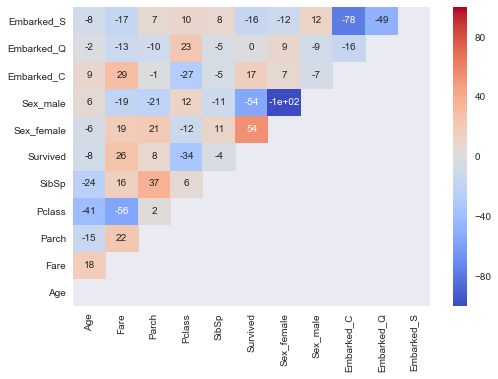

In [214]:
X_dum=pd.get_dummies(X[continuous_var+categorical_var].copy())
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')
ax.set_ylim((0,11))
plt.savefig('figures/correlogram.png')

Pairplots are mostly not useful

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


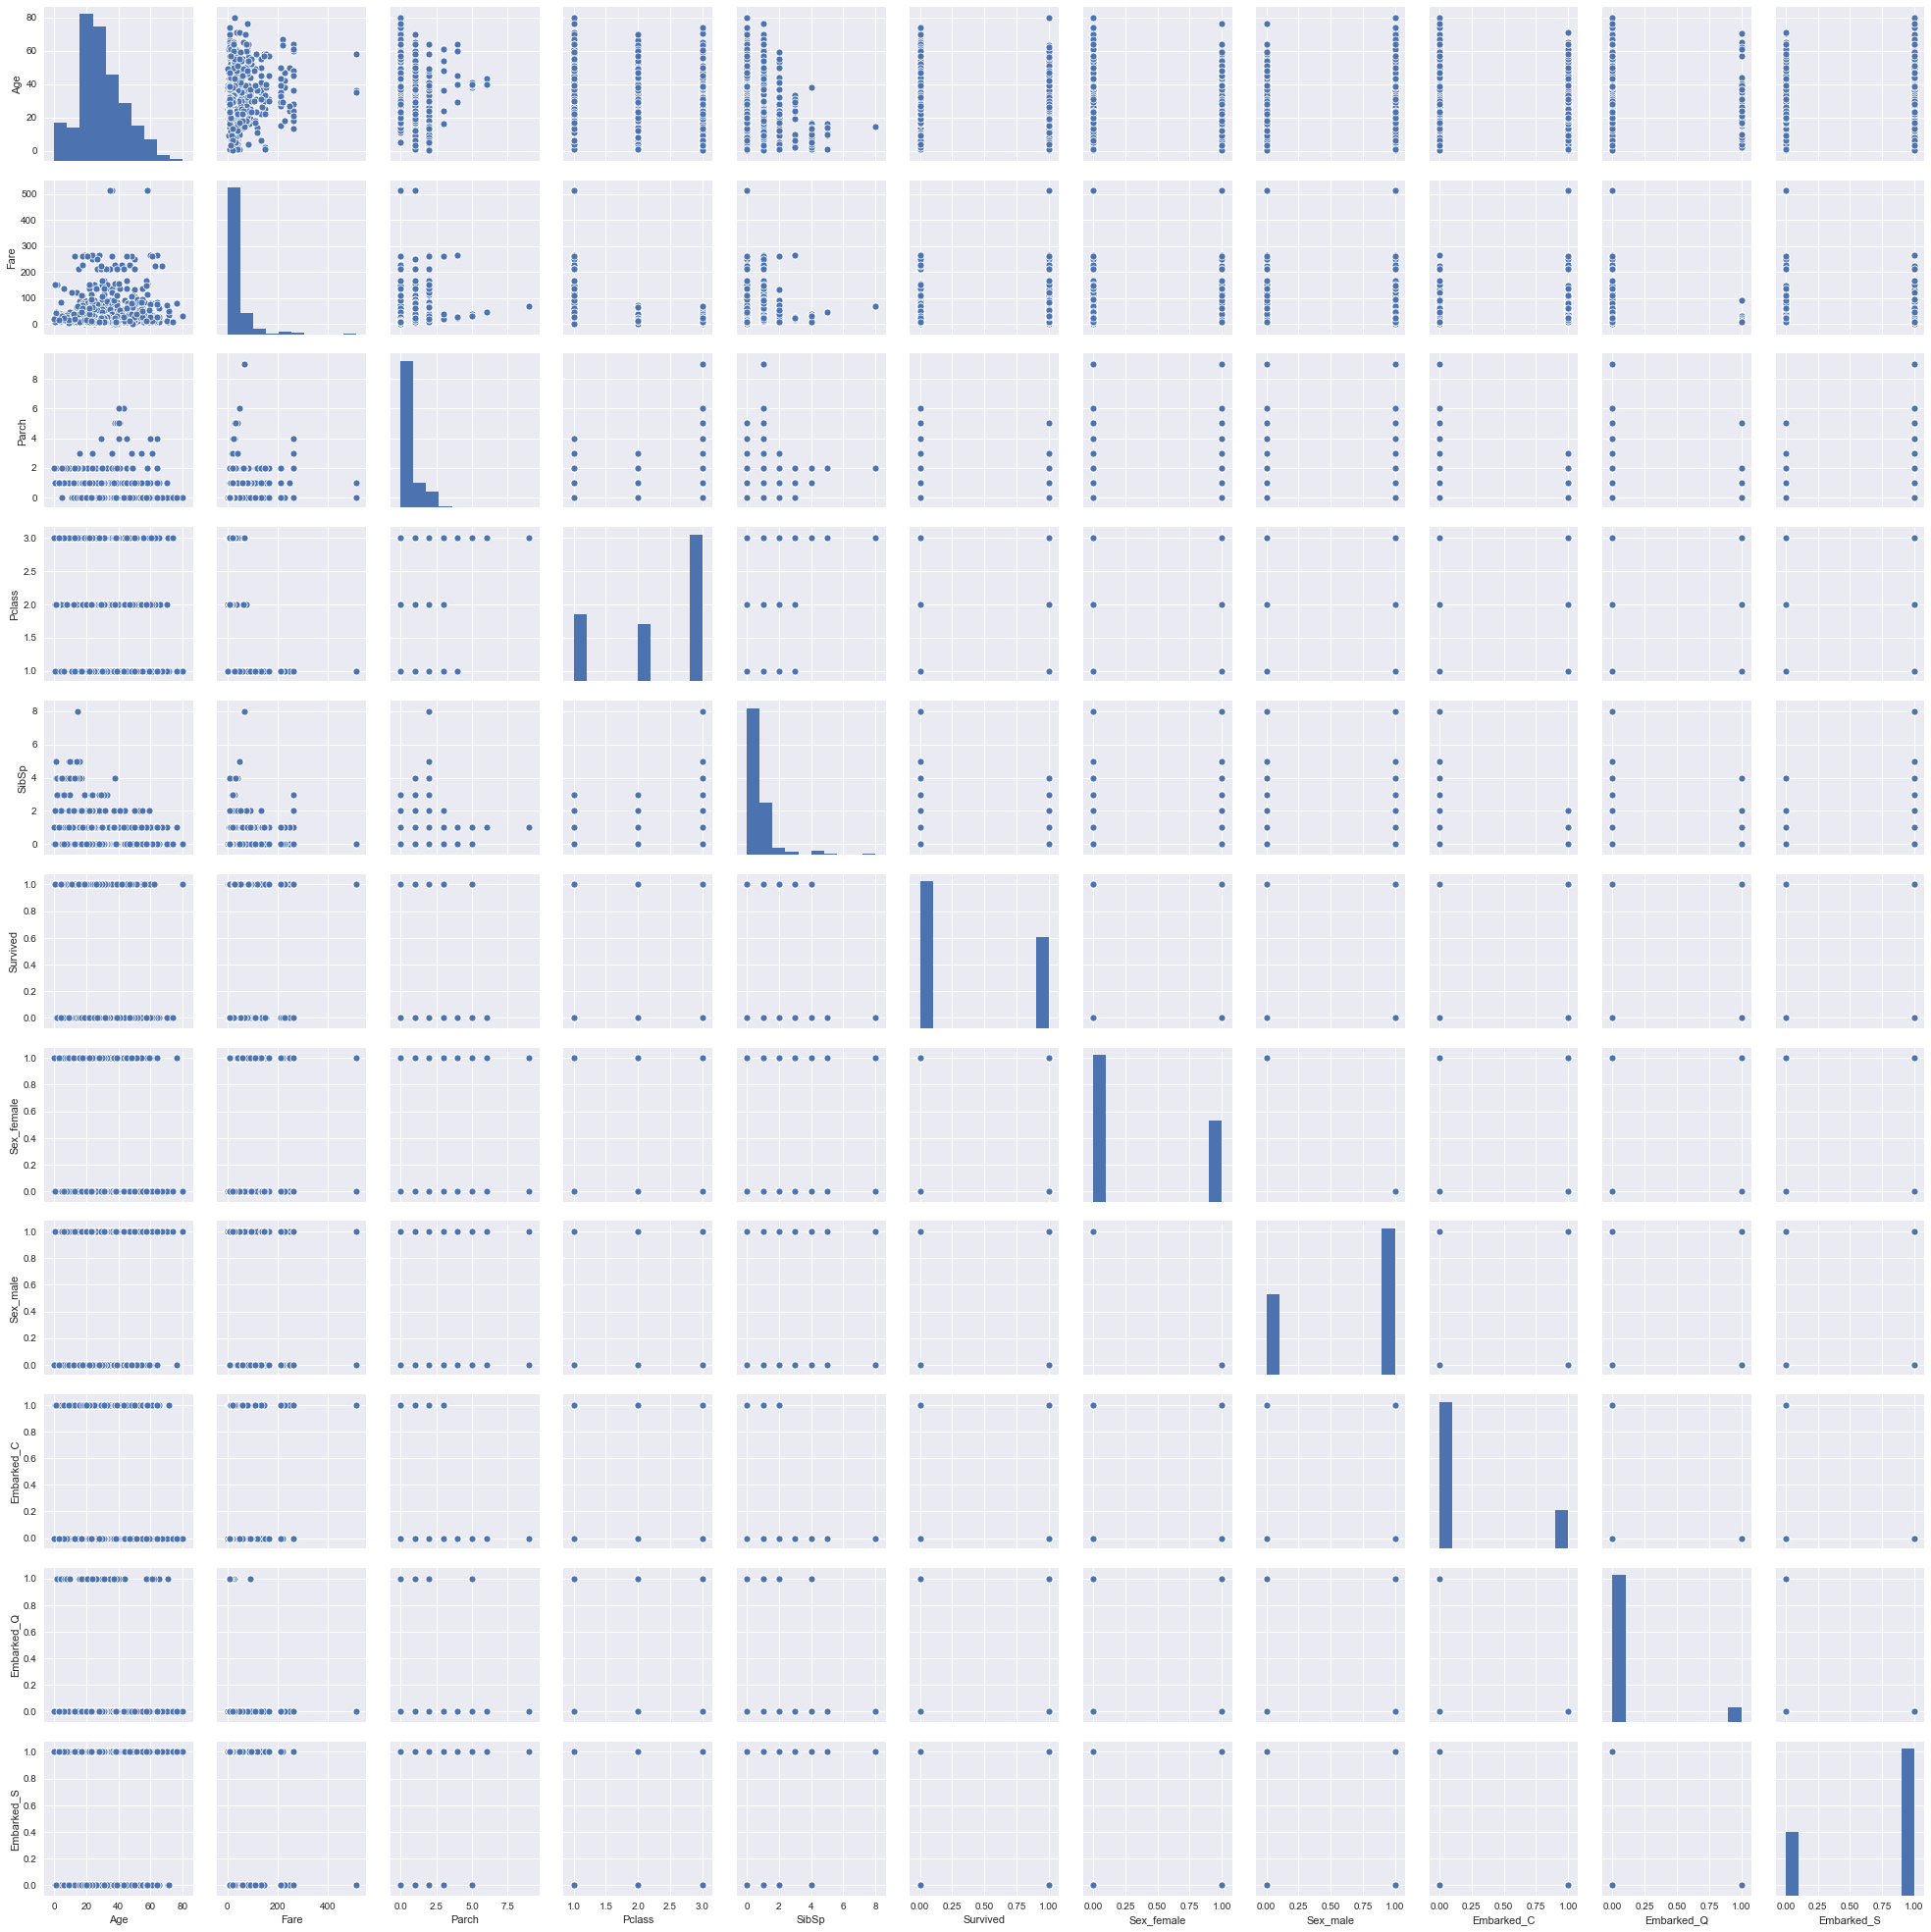

In [215]:
_ =sns.pairplot(X_dum)
plt.savefig('figures/pairplot.png')

### Histograms 

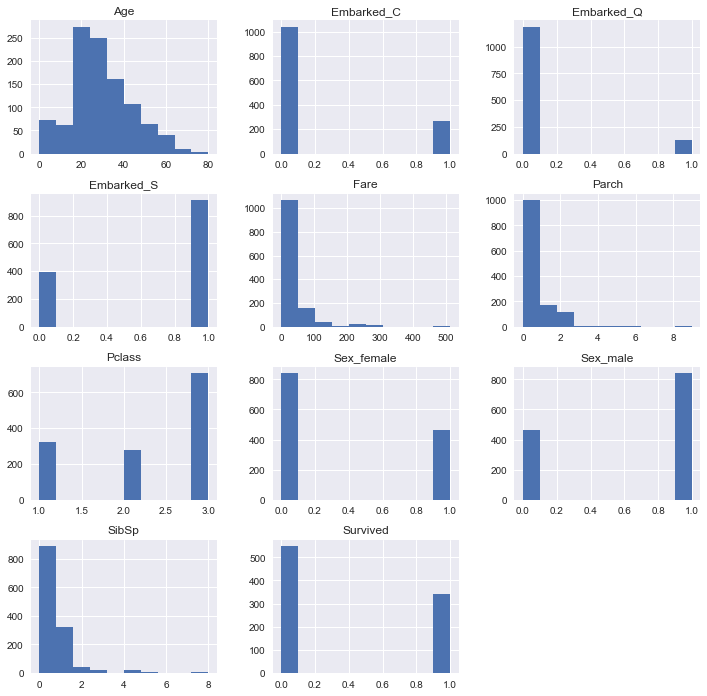

In [216]:
_ = X_dum.hist(figsize=(12,12))
plt.savefig('figures/hist_all.png')

# Looking at variable individually and creating new features

### Survivors and casualties

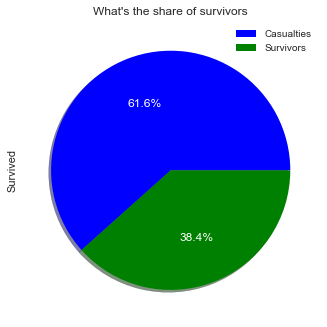

In [217]:
Fig_age_survivial = (pd.value_counts(train.Survived)
                     .plot.pie(autopct='%1.1f%%'
                               ,shadow=True
                               ,colors=['blue','green']
                               ,textprops=dict(color="w",size='12'))
                    )
plt.title('What\'s the share of survivors')
plt.legend(['Casualties','Survivors'])
plt.savefig('figures/Survived_pie.png')

### Siblings-Spouses (SibSp) and Parents-Children (Parch)
Let's see if creating a new feature **_relatives_** is helpful for the analysis


Percentages of passengers having 0 to 10 relatives

    Siblings & Spouse  Parents & children  Relatives
0                68.1                76.5       60.4
1                24.4                13.0       18.0
2                 3.2                 8.6       12.1
3                 1.5                 0.6        3.3
4                 1.7                 0.5        1.7
5                 0.5                 0.5        1.9
6                 NaN                 0.2        1.2
7                 NaN                 NaN        0.6
8                 0.7                 NaN        NaN
9                 NaN                 0.2        NaN
10                NaN                 NaN        0.8


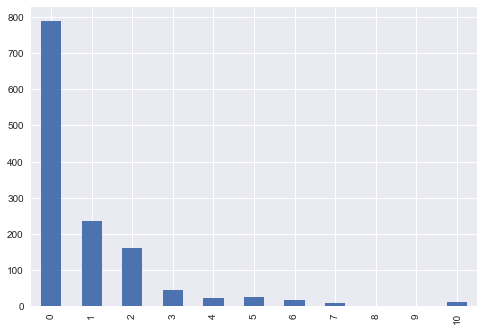

In [218]:
X['relatives'] = X.SibSp + X.Parch

Relatives = pd.DataFrame(X.SibSp.value_counts()).merge(
    pd.DataFrame(X.Parch.value_counts())
               ,left_index=True
               ,right_index=True
               ,how='outer'
              ).merge(
    pd.DataFrame(X.relatives.value_counts())
                ,left_index=True
                 ,right_index=True
                 ,how='outer'
)
Relatives.columns = ['Siblings & Spouse','Parents & children','Relatives']
print('\nPercentages of passengers having 0 to 10 relatives\n')
print(round(Relatives/X.shape[0]*100,1))

Relatives.Relatives.plot(kind='bar')
plt.savefig('figures/Relatives.png')

## Name

Some of the passengers have a certain societal rank that can be identified by the title given in the passenger list. 
1. From [wikipedia](https://en.wikipedia.org/wiki/Master_(form_of_address)) "**Master** was used in England for men of some rank, especially "free masters" of a trade guild and by any manual worker or servant employee addressing his employer (his master), but also generally by those lower in status to gentlemen, priests, or scholars."
2. There are some Drs., Reverends, Col., Majors. and a Capt.
3. Some of the women were wed (Mrs, Mme, some unwed (Miss, Ms and Mlle)

In [219]:
X.Name[:20]

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

In [220]:
title = X.Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0].strip()
                   )
title_test = test.Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0].strip()
                   )
print('\nTypes and frequencies of titles\n')
title.value_counts()#.head(100)



Types and frequencies of titles



Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Dona              1
Don               1
Sir               1
Jonkheer          1
Lady              1
Mme               1
Capt              1
the Countess      1
Name: Name, dtype: int64

##### Creating new column title_honor

In [221]:
# first, drop mrs, mr, miss and mme
title_honor = list(title.unique())
title_drop = ['Mrs', 'Mr', 'Miss', 'Mme','Mlle','Don','Dona']
for a in title_drop: title_honor.remove(a)
X['title_honor']=[a in title_honor for a in title]
test['title_honor']=[a in title_honor for a in title_test]

##### Creating new column unmarried_women

In [222]:
X[X.Sex=='female'].Name.map(lambda x: x.split(",")[1]
              ).map(lambda x: x.split(".")[0]
                   ).value_counts()#.

 Miss            260
 Mrs             197
 Mlle              2
 Ms                2
 the Countess      1
 Lady              1
 Dr                1
 Mme               1
 Dona              1
Name: Name, dtype: int64

### Creating unmarried_woman

All women that do not have the title Mrs or Mme will be labeled as unmarried.

In [223]:
X['unmarried_woman']=X.Name.map(
    lambda x:  1-bool(re.search('Mrs.|Mlle.',x)))

### Ticket and Fare
- Which passengers had the same ticket number?
- Do we have to adjust the fare for the number of people how shared the same ticket number?
- Does the ticket number give any hint to where the cabins of the passengers were?

**Still needs to be finished**

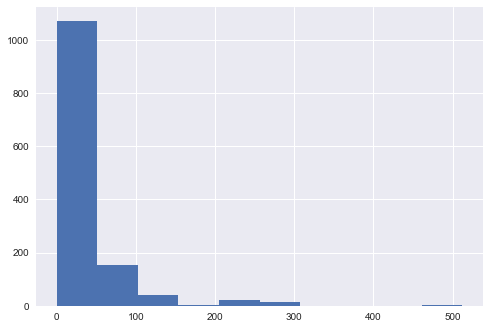

In [224]:
X.Fare.hist()

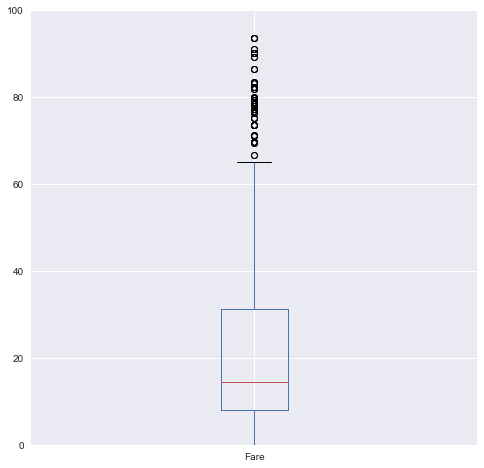

In [225]:
X.Fare.plot(kind='box',figsize=(8,8),ylim=(0,100))
X.Fare.describe().round(2)
plt.savefig('figures/Fare_boxplot.png')

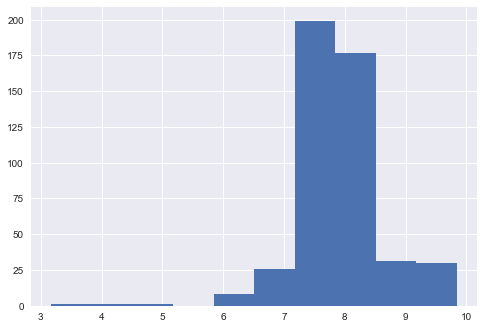

In [226]:
X.Fare[(X.Fare>0) & (X.Fare<10)].hist()
plt.savefig('figures/Fare.png')

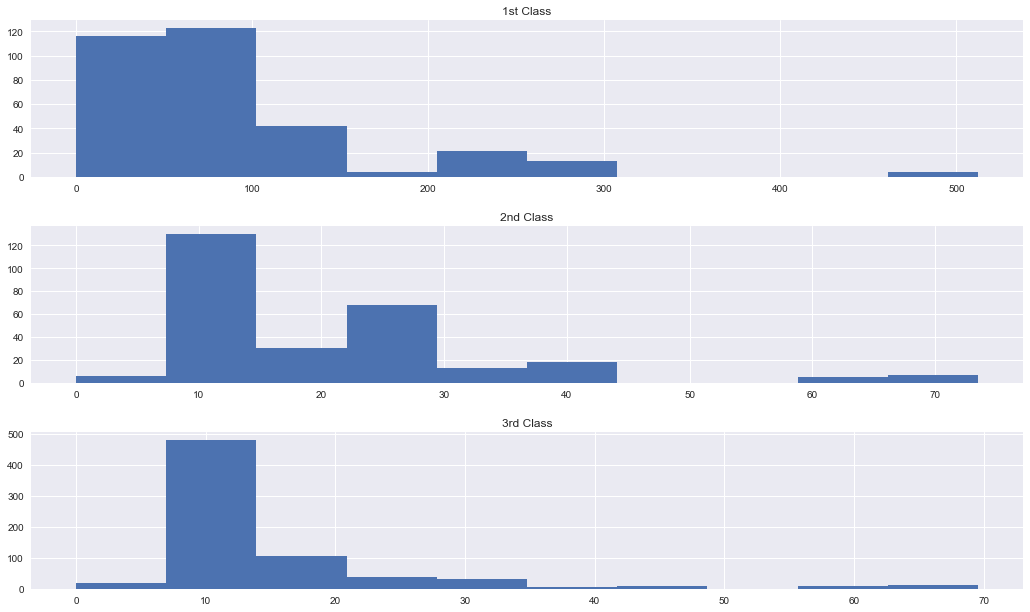

In [227]:
fig, axes = plt.subplots(3,1,figsize=(15,9))
fig.tight_layout(pad=3.0)
X.Fare[X.Pclass==1].hist(ax=axes[0])
axes[0].set_title('1st Class')
X.Fare[X.Pclass==2].hist(ax=axes[1])
axes[1].set_title('2nd Class')
X.Fare[X.Pclass==3].hist(ax=axes[2])
axes[2].set_title('3rd Class')
plt.savefig('figures/Fare_and_class.png')

In [228]:
test = X[['Ticket','Cabin','Fare','Pclass']]
test[-X.Cabin.isnull()].sort_values(by='Cabin',ascending=False)

,Ticket,Cabin,Fare,Pclass
339,113784,T,35.5000,1
394,PP 9549,G6,16.7000,3
251,347054,G6,10.4625,3
117,PP 9549,G6,16.7000,3
10,PP 9549,G6,16.7000,3
...,...,...,...,...
331,PC 17580,A18,29.7000,1
556,11755,A16,39.6000,1
475,110465,A14,52.0000,1
208,PC 17613,A11,27.7208,1


In [229]:
ticket_prefix = X.Ticket.map(lambda x: x.split()).map(lambda x: x[0] if len(x)>1   else "")
ticket_number = X.Ticket.map(lambda x: x.split()).map(lambda x: x[0] if len(x)==1   else x[1])
ticket_number.map(len).value_counts()

6    606
5    377
4    249
7     46
2     15
3     12
1      4
Name: Ticket, dtype: int64

In [230]:
import re

In [231]:
def linefinder(x):
    return re.findall('[0-9]{1,}', x)
ticket_number.map(linefinder).sort_values(ascending=False)

10     [9549]
394    [9549]
117    [9549]
300    [9234]
206    [9232]
        ...  
271        []
302        []
473        []
179        []
597        []
Name: Ticket, Length: 1309, dtype: object

### Embarkation

,Embarked,Survived,Percentages
0,C,1.0,0.553571
1,C,0.0,0.446429
2,Q,0.0,0.610390
3,Q,1.0,0.389610
4,S,0.0,0.663043
5,S,1.0,0.336957


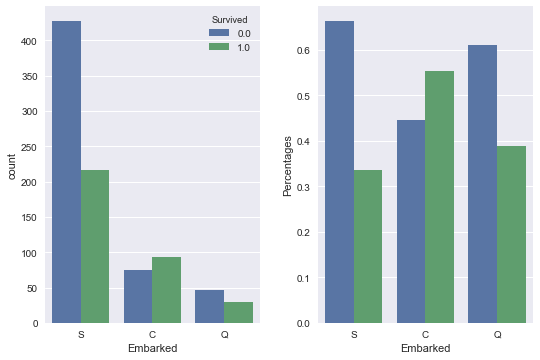

In [232]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.tight_layout(pad=3.0)
sns.countplot(x='Embarked',hue='Survived',data=X,ax=ax1,order=['S','C','Q'])

Embarked = (X['Survived']
             .groupby(X['Embarked'])
             .value_counts(normalize=True)
             .rename('Percentages')
             .reset_index()
           )
sns.barplot(x='Embarked'
            , y='Percentages'
            , hue='Survived'
            , data=Embarked
            ,ax=ax2
            ,order=['S','C','Q']
            )
ax2.get_legend().remove()
plt.savefig('figures/Embarkation.png')
Embarked

### Sex matters for survival

In [233]:
train_cat = train.select_dtypes(include='object').copy()
train_cat#value_counts()
[female_n,male_n]=[train.loc[train['Sex']=='female','PassengerId'].count(),train.loc[train['Sex']=='male','PassengerId'].count()]
sex_crosstab=round(pd.crosstab(train.Survived,train.Sex)/[female_n,male_n]*100,1)
print(sex_crosstab)



Sex       female  male
Survived              
0           25.8  81.1
1           74.2  18.9


### Passenger Class

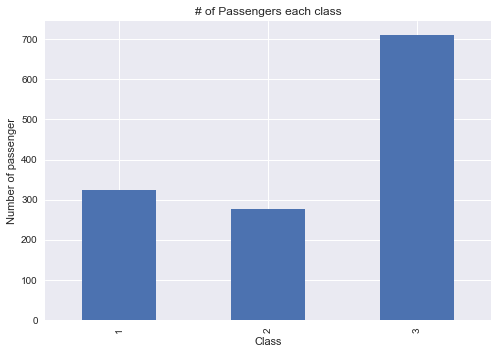

In [234]:
(pd.value_counts(X.Pclass)
 .sort_index()
 .plot
 .bar(title="# of Passengers each class")
)

plt.ylabel('Number of passenger')
plt.xlabel('Class')
plt.savefig('figures/Pclass.png')

In [235]:
class_survival=round(train.groupby(['Pclass','Survived'])['PassengerId'].agg('count')\
                    /train.groupby('Pclass').count()['PassengerId']*100,2)
class_survival

Pclass  Survived
1       0           37.04
        1           62.96
2       0           52.72
        1           47.28
3       0           75.76
        1           24.24
Name: PassengerId, dtype: float64

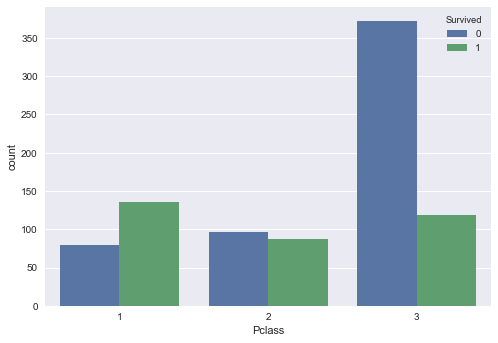

In [236]:
sns.countplot(x='Pclass',data=train, hue='Survived')
plt.savefig('figures/Pclass_survival.png')


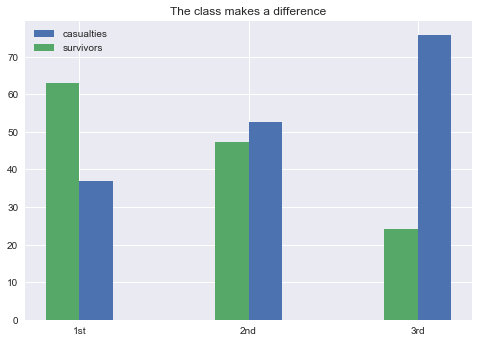

In [237]:
tt = class_survival.reset_index().set_index('Pclass')
survived = tt[tt['Survived']==0].PassengerId
dead = tt[tt['Survived']==1].PassengerId
plt.bar([1.2,2.2,3.2],survived, width=0.2)
plt.bar([1,2,3],dead,width=0.2)
plt.xticks([1.1,2.1,3.1], ['1st', '2nd', '3rd'])
plt.legend(['casualties','survivors'])
plt.title('The class makes a difference')
plt.savefig('figures/Pclass_percentages.png')

### Age of passengers

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


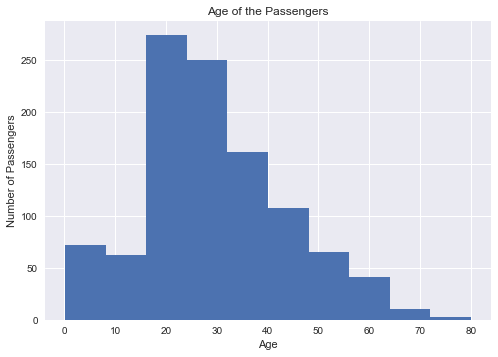

In [238]:
print(X.Age.describe())
X.Age.hist()
plt.title('Age of the Passengers')
plt.ylabel('Number of Passengers')
plt.xlabel('Age')
plt.savefig('figures/ageHist.png')


## Building a preprocessing pipeline

In [239]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 15 columns):
Age                1046 non-null float64
Cabin              295 non-null object
Embarked           1307 non-null object
Fare               1308 non-null float64
Name               1309 non-null object
Parch              1309 non-null int64
PassengerId        1309 non-null int64
Pclass             1309 non-null int64
Sex                1309 non-null object
SibSp              1309 non-null int64
Survived           891 non-null float64
Ticket             1309 non-null object
relatives          1309 non-null int64
title_honor        1309 non-null bool
unmarried_woman    1309 non-null int64
dtypes: bool(1), float64(3), int64(6), object(5)
memory usage: 194.7+ KB


In [253]:
categoric_features = list(X.columns[X.dtypes==object])
categoric_features.remove('Name')
categoric_features.remove('Ticket')
categoric_features.remove('Cabin')
categoric_features

['Embarked', 'Sex']

In [254]:
numeric_features = list(X.columns[X.dtypes!=object])
numeric_features.remove('PassengerId')
numeric_features.remove('Survived')

numeric_features

['Age',
 'Fare',
 'Parch',
 'Pclass',
 'SibSp',
 'relatives',
 'title_honor',
 'unmarried_woman']

In [288]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categoric_features)
    ])

### Splitting data and preprocessing for later tests and validations

In [257]:
y_train = X[-np.isnan(X.Survived)].Survived
X_train = X[-np.isnan(X.Survived)].drop('Survived',axis=1)
X_test = X[np.isnan(X.Survived)].drop('Survived',axis=1)


In [259]:
X_train_cal, X_valid, y_train_cal, y_valid = train_test_split(X_train,y_train,random_state=42)

In [367]:
X_train_cal_transformed = preprocessor.fit_transform(X_train_cal)
X_valid_transformed = preprocessor.transform(X_valid)

Preparing Data for models using all data available

In [336]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

### Build the pipeline with logistic regression for a start, split data in train, validation and test

In [256]:
reg = Pipeline(steps=[('preprocessor', preprocessor),
                      
                      ('classifier', LogisticRegression(solver='liblinear'))
                       
                      ])

In [261]:
y_train_pred = cross_val_predict(reg, X_train_cal, y_train_cal,
                              cv=5,method='predict')

y_train_scores = cross_val_predict(reg, X_train_cal, y_train_cal,
                              cv=5,method='decision_function')

### A quick glance at some standard diagnostics
Getting the confusion matrics, scores and plotting the standard plots 
- precision-recall curve
- roc curve

Confusion matrix: 

 [[364  51]
 [ 68 185]] 

The accuracy for threshold 0: 0.82
The f1-score: 0.76


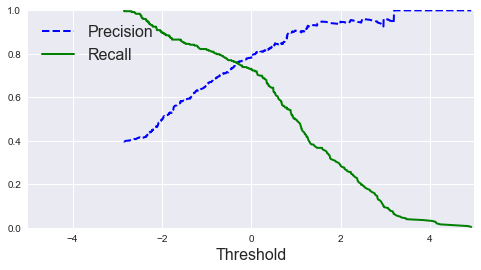

In [262]:
print('Confusion matrix: \n\n',confusion_matrix(y_train_cal,y_train_scores>0),'\n')
print('The accuracy for threshold 0:', round(accuracy_score(y_train_cal,y_train_scores>0),2))
print('The f1-score:', round(f1_score(y_train_cal,y_train_scores>0),2))


precisions, recalls, thresholds = precision_recall_curve(y_train_cal, y_train_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.xlim([-5, 5])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

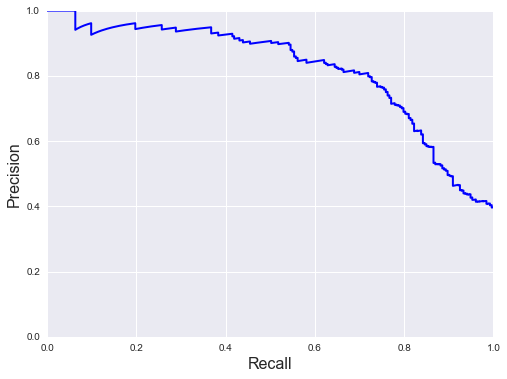

In [263]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)


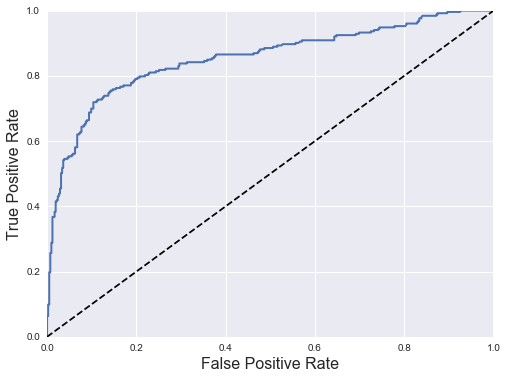

In [264]:
fpr, tpr, thresholds = roc_curve(y_train_cal,y_train_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)


In [265]:
print('The ROC AUC score is: ',round(roc_auc_score(y_train_cal,y_train_scores),2))

The ROC AUC score is:  0.85


### Optimizing hyperparameters

Looking at standard hyperparameters

In [266]:
LogisticRegression()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Starting a first attempt just checking out l1 and l2

In [268]:
param_grid = {'penalty':('l1','l2')}
lr_ = LogisticRegression(solver='liblinear')

clf = GridSearchCV(lr_,param_grid, cv=5, scoring='accuracy')
clf.fit(preprocessor.transform(X_train_cal), y_train_cal)
pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003870,0.000853,0.000648,0.000108,l1,{'penalty': 'l1'},0.813433,0.880597,0.791045,0.789474,0.849624,0.824850,0.035358,1
1,0.003111,0.001815,0.000503,0.000113,l2,{'penalty': 'l2'},0.813433,0.873134,0.791045,0.796992,0.834586,0.821856,0.029791,2


In [269]:
print("Logit with \nl1 regularization:", round(clf.cv_results_['mean_test_score'][0],5))
print("l2 regularization:", round(clf.cv_results_['mean_test_score'][1],5))

Logit with 
l1 regularization: 0.82485
l2 regularization: 0.82186


### Extending the grid to different values of regularization parameter C

In [300]:
param_grid = {'penalty':('l1','l2')
              ,'C':[0.1,0.5,1,1.5,2,2.3,2.4,2.5,3.5,4,4.5,5]}
lr_ = LogisticRegression(solver='liblinear')

clf_logistic = GridSearchCV(lr_,param_grid, cv=5, scoring='accuracy')
clf_logistic.fit(X_train_cal_transformed, y_train_cal)
pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.092373,0.002785,0.005724,0.000442,70,{'n_estimators': 70},0.798507,0.783582,0.791045,0.842105,0.827068,0.808383,0.022342,1
3,0.017335,0.001292,0.001570,0.000274,12,{'n_estimators': 12},0.783582,0.798507,0.791045,0.834586,0.827068,0.806886,0.020180,2
5,0.018635,0.000267,0.001628,0.000308,14,{'n_estimators': 14},0.776119,0.805970,0.783582,0.827068,0.834586,0.805389,0.023035,3
6,0.026109,0.000479,0.002099,0.000397,20,{'n_estimators': 20},0.776119,0.783582,0.783582,0.834586,0.834586,0.802395,0.026328,4
7,0.039871,0.000839,0.002603,0.000131,30,{'n_estimators': 30},0.791045,0.783582,0.783582,0.827068,0.827068,0.802395,0.020254,4
8,0.066350,0.000956,0.004698,0.000554,50,{'n_estimators': 50},0.791045,0.768657,0.783582,0.834586,0.827068,0.800898,0.025504,6
2,0.017427,0.000628,0.001829,0.000390,11,{'n_estimators': 11},0.768657,0.791045,0.776119,0.827068,0.834586,0.799401,0.026669,7
10,0.130771,0.001905,0.007756,0.000347,100,{'n_estimators': 100},0.791045,0.753731,0.776119,0.834586,0.842105,0.799401,0.033922,7
1,0.018332,0.001488,0.001696,0.000585,10,{'n_estimators': 10},0.776119,0.783582,0.798507,0.819549,0.812030,0.797904,0.016414,9
4,0.017356,0.000296,0.001550,0.000159,13,{'n_estimators': 13},0.776119,0.783582,0.776119,0.819549,0.819549,0.794910,0.020227,10


In [301]:
print(clf_logistic.best_estimator_)
print(clf_logistic.best_params_)
round(clf_logistic.best_score_,3)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 0.1, 'penalty': 'l2'}


0.826

### Checking the score on the validation set

In [368]:
predict_valid = clf_logistic.predict(X_valid_transformed)
print('Validation score: ',round(accuracy_score(y_valid,predict_valid),3))

Validation score:  0.789


Preparing for submission

In [313]:
clf_logistic_best = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [314]:
clf_logistic_best.fit(preprocessor.fit_transform(X_train),y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [316]:
#submission_predict = clf_logistic_best.predict(preprocessor.transform(X_test))

## Random Forest

Checking out how standard parameters perform

Median accuracy:  0.806


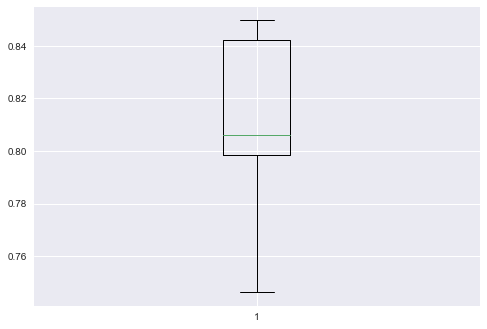

In [370]:
clf_ = Pipeline(steps=[('preprocessor', preprocessor),
                      
                      ('classifier', RandomForestClassifier(n_estimators=50))
                       
                      ])
clf_scores = cross_val_score(clf_, X_train_cal, y_train_cal,
                              cv=5)

plt.boxplot(clf_scores)
print('Median accuracy: ',round(np.median( clf_scores),3))

Tweaking # of estimators

In [371]:
param_grid = {'n_estimators':[5,10,11,12,13,14,20,30,50,70,100]}
randf_ = RandomForestClassifier(random_state=42)

clf = GridSearchCV(randf_,param_grid
                   , cv=5, scoring='accuracy')
clf.fit(X_train_cal_transformed, y_train_cal)
pd.DataFrame(clf.cv_results_).sort_values(by='mean_test_score',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.097499,0.004477,0.005878,0.000538,70,{'n_estimators': 70},0.798507,0.783582,0.791045,0.842105,0.827068,0.808383,0.022342,1
3,0.017240,0.000563,0.001755,0.000405,12,{'n_estimators': 12},0.783582,0.798507,0.791045,0.834586,0.827068,0.806886,0.020180,2
5,0.020112,0.001015,0.001580,0.000135,14,{'n_estimators': 14},0.776119,0.805970,0.783582,0.827068,0.834586,0.805389,0.023035,3
6,0.027584,0.000744,0.002311,0.000686,20,{'n_estimators': 20},0.776119,0.783582,0.783582,0.834586,0.834586,0.802395,0.026328,4
7,0.040444,0.000891,0.002859,0.000612,30,{'n_estimators': 30},0.791045,0.783582,0.783582,0.827068,0.827068,0.802395,0.020254,4
8,0.069050,0.003406,0.004176,0.000714,50,{'n_estimators': 50},0.791045,0.768657,0.783582,0.834586,0.827068,0.800898,0.025504,6
2,0.016427,0.001089,0.001374,0.000052,11,{'n_estimators': 11},0.768657,0.791045,0.776119,0.827068,0.834586,0.799401,0.026669,7
10,0.158329,0.018064,0.010066,0.002798,100,{'n_estimators': 100},0.791045,0.753731,0.776119,0.834586,0.842105,0.799401,0.033922,7
1,0.015717,0.003296,0.002405,0.001232,10,{'n_estimators': 10},0.776119,0.783582,0.798507,0.819549,0.812030,0.797904,0.016414,9
4,0.018312,0.000429,0.001748,0.000583,13,{'n_estimators': 13},0.776119,0.783582,0.776119,0.819549,0.819549,0.794910,0.020227,10


In [372]:
print('Best estimator: ',clf.best_params_)
print('Best score: ',round(clf.best_score_,3))

Best estimator:  {'n_estimators': 70}
Best score:  0.808


In [373]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [375]:
clf_random = RandomizedSearchCV(estimator = randf_
                               , param_distributions = random_grid
                               , n_iter = 100
                               , cv = 3
                               , verbose=2
                               , random_state=42
                               , n_jobs = -1)
# Fit the random search model
clf_random.fit(X_train_cal_transformed, y_train_cal)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [376]:
print('Best score:', round(clf_random.best_score_,3))
print('Best model:', clf_random.best_params_)

Best score: 0.825
Best model: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


Checking the validation score

In [279]:
random_pred = clf_random.predict(preprocessor.transform(X_valid))
print('Validation score: ',round(accuracy_score(y_valid,random_pred),3))

Validation score:  0.825


In [289]:
clf_rf = RandomForestClassifier(n_estimators=1000
                       ,min_samples_leaf=2
                       ,min_samples_split=5
                       ,max_features='sqrt'
                       ,bootstrap='True'
                      )

In [292]:
clf_random = Pipeline(steps=[('preprocessor', preprocessor),
                      
                      ('classifier', clf_rf)
                       
                      ])

In [293]:
cross_val_score(clf_random, X_train_cal, y_train_cal,
                              cv=5,scoring='accuracy')

array([0.81343284, 0.88059701, 0.78358209, 0.81954887, 0.84210526])

In [295]:
clf_random_full = clf_random.fit(X_train,y_train)

In [ ]:
submission_predict = clf_random_full.predict(X_test)

### XGBoost

In [360]:
xgb_ = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
X_train_cal_transformed = preprocessor.fit_transform(X_train_cal)
xgb_.fit(X_train_cal_transformed,y_train_cal)#,  early_stopping_rounds=5)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [361]:
xgb_predict = xgb_.predict(preprocessor.transform(X_valid))
accuracy_score(y_valid,xgb_predict)

0.8116591928251121

In [362]:
xgb_.fit(X_train_transformed,y_train)#,  early_stopping_rounds=5)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [363]:
#submission_predict = xgb_.predict(X_test_transformed)

### Preparing submission

In [365]:
submission = pd.DataFrame({'PassengerId':X_test.PassengerId,'Survived':submission_predict.astype(int)})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [366]:
submission.to_csv('private/submission.csv',index=False)
submission.shape

(418, 2)